# EXPERIMENT - WEEK 3

#### Importing packages

In [25]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import pickle

#### Loading cleaned dataset from week 3 experiment

In [2]:
train_df = pd.read_csv('../data/interim/cleaned_train_data_draft_pred.csv')
test_df = pd.read_csv('../data/interim/cleaned_test_data_draft_pred.csv')

In [4]:
train_df.head(2)

,team,conf,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,...,dgbpm,oreb,dreb,treb,ast,stl,blk,pts,player_id,drafted
0,South Alabama,SB,26,29.5,97.3,16.6,42.5,44.43,1.6,4.6,...,-1.941150,0.1923,0.6154,0.8077,1.1923,0.3462,0.0385,3.8846,7be2aead-da4e-4d13-a74b-4c1e692e2368,0.0
1,Utah St.,WAC,34,60.9,108.3,14.9,52.4,54.48,3.8,6.3,...,-0.247934,0.6765,1.2647,1.9412,1.8235,0.4118,0.2353,5.9412,61de55d9-1582-4ea4-b593-44f6aa6524a6,0.0


In [5]:
test_df.head(2)

,team,conf,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,...,ogbpm,dgbpm,oreb,dreb,treb,ast,stl,blk,pts,player_id
0,Morgan St.,MEAC,2,3.0,115.1,4.7,50.0,50.00,0.0,4.6,...,-2.46774,-2.27566,0.0000,0.3333,0.3333,0.0000,0.0000,0.0,1.0000,cf302b4d-84f7-4124-a25d-a75eed31978b
1,South Carolina St.,MEAC,11,17.6,61.1,18.6,34.7,35.18,2.5,15.7,...,-7.49472,-4.41253,0.2727,1.4545,1.7273,0.4545,0.1818,0.0,2.3636,f91837cd-4f49-4b70-963d-aeb82c6ce3da


In [6]:
%load_ext autoreload
%autoreload 2

In [11]:
categorical_features = train_df.set_index('drafted').select_dtypes(include='object').reset_index().drop('player_id', axis=1)

In [12]:
categorical_features.head(5)

,drafted,team,conf,yr
0,0.0,South Alabama,SB,So
1,0.0,Utah St.,WAC,So
2,0.0,South Florida,BE,Sr
3,0.0,Pepperdine,WCC,Sr
4,0.0,Pacific,BW,Sr


In [13]:
from scipy.stats import chi2_contingency
for col in categorical_features.columns:
    if col != 'drafted':
        corr_tab = pd.crosstab(categorical_features[col], categorical_features['drafted'])
        print(corr_tab)
        chi2_score, p_val, deg , expected_val = chi2_contingency(corr_tab)
        if p_val <= 0.05:
            print(str(col)+ ":"  + " :has a significant correlation with drafted, H0 is rejected")
        else:
            print(str(col) + ":" + " :DOESN'T have a significant correlation with drafted, H0 is NOT rejected")
                

drafted            0.0  1.0
team                       
Abilene Christian   90    0
Air Force          202    0
Akron              166    0
Alabama            156    2
Alabama A&M        171    0
...                ...  ...
Wright St.         156    0
Wyoming            150    2
Xavier             167    4
Yale               181    1
Youngstown St.     161    0

[358 rows x 2 columns]
team: :has a significant correlation with drafted, H0 is rejected
drafted   0.0  1.0
conf              
A10      2258   10
ACC      2191  106
AE       1394    0
AMER     1037   10
ASUN     1463    0
B10      2069   54
B12      1653   61
BE       1927   50
BSKY     1632    3
BSTH     1723    0
BW       1434    1
CAA      1633    7
CUSA     2104    9
GWC       324    0
HORZ     1517    6
IND       440    0
IVY      1477    1
MAAC     1638    0
MAC      1913    1
MEAC     2026    1
MVC      1544    2
MWC      1571   18
NEC      1690    0
OVC      1762    7
P10       398   17
P12      1438   63
PAT      1588 

In [14]:
from src.data.encoders import perform_one_hot_encoding, perform_label_encoding

In [15]:
to_encode = ['conf', 'yr']
train_df_one_enc, test_df_one_enc = perform_one_hot_encoding(train_df, test_df, to_encode)

In [16]:
train_df_one_enc.head(5)

,team,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,...,conf_SEC,conf_SLND,conf_SUM,conf_SWAC,conf_WAC,conf_WCC,yr_Fr,yr_Jr,yr_So,yr_Sr
0,South Alabama,26,29.5,97.3,16.6,42.5,44.43,1.6,4.6,15.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Utah St.,34,60.9,108.3,14.9,52.4,54.48,3.8,6.3,13.6,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,South Florida,27,72.0,96.2,21.8,45.7,47.98,2.1,8.0,14.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,Pepperdine,30,44.5,97.7,16.0,53.6,53.69,4.1,9.4,13.7,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,Pacific,33,56.2,96.5,22.0,52.8,54.31,8.3,18.6,8.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


##### NOTE: Removing team from the feature set as new values are seen in the test data. To be dealt in next experiment

In [17]:
train_df_one_enc = train_df_one_enc.drop('team', axis=1)
test_df_one_enc = test_df_one_enc.drop('team', axis=1)

In [18]:
train_df_one_enc = train_df_one_enc.fillna(0)
test_df_one_enc = test_df_one_enc.fillna(0)

In [19]:
train_df_one_enc.to_csv('../data/processed/train_data_ohe_processed.csv', index=False)
test_df_one_enc.to_csv('../data/processed/test_data_ohe_processed.csv', index=False)

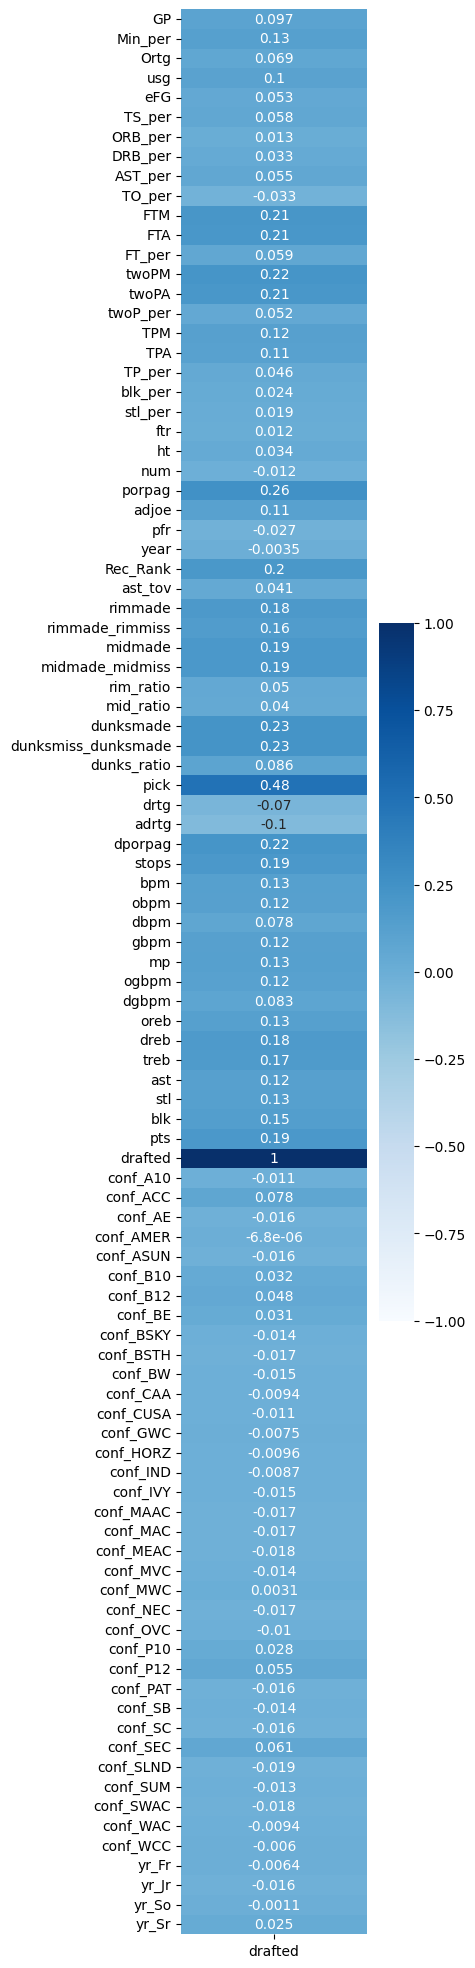

In [20]:
corr = train_df_one_enc.drop(['player_id'],axis=1).corr()
plt.figure(figsize=(3, 25))
heatmap = sns.heatmap(corr[['drafted']], vmin=-1, vmax=1, cmap='Blues', annot=True)

#### MODEL PROCESSING

In [21]:
X_train = train_df_one_enc.drop(['drafted', 'player_id'], axis=1)
y_train = train_df_one_enc[['drafted']]

In [22]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from src.data.model_train import perform_model_train
import warnings
warnings.filterwarnings('ignore')

model = GradientBoostingClassifier()
perform_model_train(model, X_train, y_train, split_size=10, save_model=True)

/home/ronik/.cache/pypoetry/virtualenvs/kaggle-assignments-package-DhrmevLr-py3.9/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ronik/.cache/pypoetry/virtualenvs/kaggle-assignments-package-DhrmevLr-py3.9/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ronik/.cache/pypoetry/virtualenvs/kaggle-assignments-package-DhrmevLr-py3.9/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ronik/.cac

------------------------------------------------------------
TRAIN SCORES for GradientBoostingClassifier()
------------------------------------------------------------
Precision Score: 0.9159528479047101 +- 0.005497858338727412
Recall Score: 0.8420298445916343 +- 0.014372022961379852
F1 Score: 0.8773607659187335 +- 0.007456897507787259
AUC score: 0.9994551399928607 +- 4.3202585794432226e-05
------------------------------------------------------------
TEST SCORES for GradientBoostingClassifier()
------------------------------------------------------------
Precision Score: 0.7832329385972853 +- 0.08602559930126617
Recall Score: 0.7126484975541578 +- 0.050738704169011585
F1 Score: 0.7447467634543946 +- 0.05758081609742767
AUC score: 0.9981577395528831 +- 0.0005455034525351979
SAVED MODEL


In [23]:
model = LogisticRegression()
perform_model_train(model, X_train, y_train, split_size=10, save_model=True)

/home/ronik/.cache/pypoetry/virtualenvs/kaggle-assignments-package-DhrmevLr-py3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ronik/.cache/pypoetry/virtualenvs/kaggle-assignments-package-DhrmevLr-py3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ronik/.cache/pypoetry/virtualenvs/kaggle-assignments-package-DhrmevLr-py3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/

------------------------------------------------------------
TRAIN SCORES for LogisticRegression()
------------------------------------------------------------
Precision Score: 0.6562639199502265 +- 0.009058263288478214
Recall Score: 0.4869341855450461 +- 0.01763270058483553
F1 Score: 0.5589497859226739 +- 0.013709753728887043
AUC score: 0.9953634472249439 +- 0.00012852526836570384
------------------------------------------------------------
TEST SCORES for LogisticRegression()
------------------------------------------------------------
Precision Score: 0.6508461460566723 +- 0.08516969657240217
Recall Score: 0.47211740041928724 +- 0.03850053295425432
F1 Score: 0.5426786074063662 +- 0.022446080691563886
AUC score: 0.9950597574178905 +- 0.0008727944282137328
SAVED MODEL


In [26]:
model = XGBClassifier()
perform_model_train(model, X_train, y_train, split_size=10, save_model=True)

/home/ronik/.cache/pypoetry/virtualenvs/kaggle-assignments-package-DhrmevLr-py3.9/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/ronik/.cache/pypoetry/virtualenvs/kaggle-assignments-package-DhrmevLr-py3.9/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/ronik/.cache/pypoetry/virtualenvs/kaggle-assignments-package-DhrmevLr-py3.9/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/ronik/.cache/pypoetry/virtualenvs/kaggle-assignments-package-DhrmevLr-py3.9/l

------------------------------------------------------------
TRAIN SCORES for XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
------------------------------------------------------------
Precision Score: 1.0 +- 0.0
Recall Score: 1.0 +- 0.0
F1 Score: 1.0 +- 0.0
AUC score: 1.0 +- 3.700743415417188

In [27]:
test_df_one_enc = test_df_one_enc.drop('player_id', axis=1)

In [28]:
loaded_model = pickle.load(open('../models/at1_week3_model/model_XGBCl.sav', 'rb'))
result = pd.DataFrame(loaded_model.predict_proba(test_df_one_enc))[1]

In [29]:
test_df['drafted'] = result

In [30]:
test_df[['player_id', 'drafted']].to_csv('../models/scores_week_3/scores_week3_draft_xgb.csv', index=False)